In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys

### 定義常數參數

In [2]:
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000

定義Dn的平方根函數 Dnsqt(wla, T)，這個函數將在後面用來生成Dsqt陣列。

生成Dsqt陣列，用來對生成的隨機數進行傅立葉轉換。

定義變數Ncomp，代表模擬的次數。

定義Efsum陣列，作為結果的總和。

In [3]:
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp=5

#define the starting sum of the result
Efsum = np.zeros(2*M)

用for循環，執行Ncomp次模擬。

在每一次模擬中，生成隨機數，並使用它們來生成電場的傅立葉轉換Ef。

正規化Ef，然後計算它的傅立葉逆變換En。

計算En的自相關函數Eautoc，並使用傅立葉變換轉換為Eautocf。

把Eautocf陣列的實部加到Efsum中。

顯示進度條。

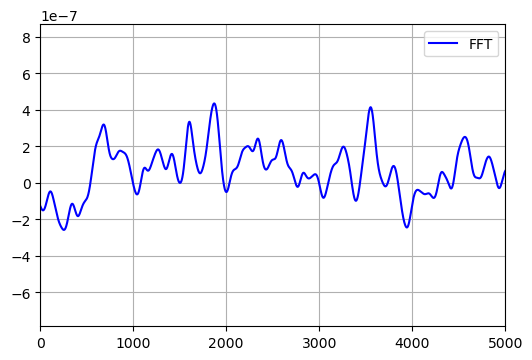

In [4]:
#for i in range(Ncomp):
    
    #generate random numbers
M0 = np.random.normal(0,1)
Mlp = np.random.normal(0,1,M-1)
Nlp = np.random.normal(0,1,M-1)
MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
Eflm = np.flip(np.conjugate(Eflp))
EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
Efn = deltap*T/np.sqrt(tsim)*Ef
En = np.fft.ifft(Efn)
    
    #we compute self correlation of En
Eautoc = signal.correlate(En,En)
Eautocf = np.fft.fft(Eautoc[len(En)-1:])
    
    #extract the real value and add the value of this loop to the total sum
Eautocf = np.real(Eautocf)
Efsum += Eautocf
    
    #generate some feedback to check the progress of the loop
    #x = i/Ncomp*100
    #sys.stdout.write('\r')
    #sys.stdout.write("[%-20s] %d%%" % ('😁'*int(x), int(x)))
    #sys.stdout.flush()
    #sleep(0.0001)
fig = plt.figure(dpi=100)
plt.plot(np.real(En),'b',label = 'FFT',linewidth=1.5)
plt.xlim(0,5000)
plt.legend()
plt.grid()
plt.show()

循環結束後，計算Efavg陣列，即Efsum除以Ncomp。

將Efavg陣列保存到文件中。

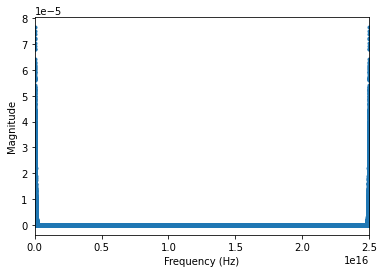

In [11]:
freqs = np.linspace(0,25*1e15,4194304)
plt.plot(freqs,Eautocf,'.')
plt.xlim(0,25e15)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [5]:
#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it
np.savez("Efavg_v2.npz", Efavg_30000 = Efavg)
data = np.load("Efavg_v2.npz")
data = dict(data)
data["Efavg_50000"] = Efavg
np.savez("Efavg_v2.npz",**data)